# Revealing representative "typical" day-types using traffic data observation and clustering

This exercise can be divided to two parts. Both give you the toolsets of methods for exploring, visualazing and evaluating day clusterings.

## Data preparation

In [3]:
import pandas as pd
import numpy as np

data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")


Your objective here is to reveal representative day-type clusters; hence, we cluster days. The provided dataset is 5-minute observations on highway microwave sensors and needs to be in a format ready for day clustering. Thus, we represent days as ordered vectors of day-time observations of size 288 (there are 288, 5-minute time observations)

In [4]:
data_df.sort_values(["Date","Interval_5"])
days = np.unique(data_df[['Date']].values.ravel())
ndays = len(days)
day_subsets_df = data_df.groupby(["Date"])
ndays = len(day_subsets_df)
nintvals = 288
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)
for i in range(0, ndays):
  df_t = day_subsets_df.get_group(days[i])
  for j in range(len(df_t)):
      df_t = day_subsets_df.get_group(days[i])
      vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]
print(vectorized_day_dataset)

[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


* STEP 1: We ensure the ordering of days and intervals is proper. The data integer representation and indexing of time intervals allow a simple order of data.
* STEP 2: We get all unique days in the dataset to know the number and their list
* STEP 3: We could do the same of time-intervals, but here we know it is 288
* STEP 4: We create new datasets where rows are days and columns are day-time interval observations. *Note that if you plan to reveal network-wide day-types, this day vector can be ordered vector of SENSORS * TIME-INTERVALS.*
* STEP 5: fill in data to the right indexes.

# Part 1: Data exploration

It is always good practice to explore data you work with for outliers or pattern existence, as it can impact the revealed patterns and their predictions.

In [5]:

print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

number of nans 277
rate of nans 0.0026350837138508373


In the dataset, we have only missing 277 values, which is 0.26%. Let us check its distribution in the dataset. First, missing data could be related to night hours, with a higher possibility of no vehicle observations.

(288,)


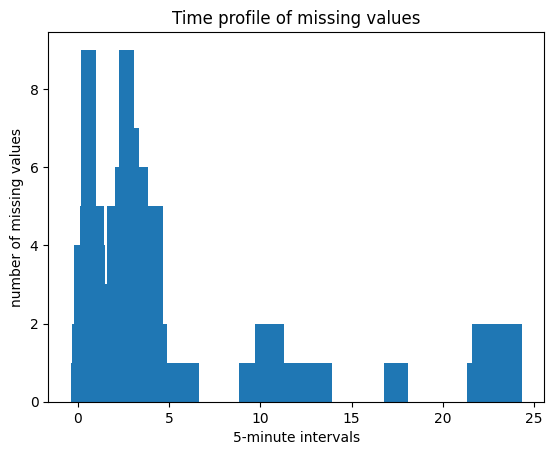

In [6]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_axis = np.arange(0, nintvals, 1, dtype=int)
x_axis_hours = []
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('5-minute intervals')
ax.set_title('Time profile of missing values')

plt.show()

Are these missing values associated with just a few days?

In [7]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


What does the data look like? What is the traffic pattern? Below is the script that can help you visualize all days where overlapping transparencies highlight some patterns. The black line is the average yearly flow for a time interval.

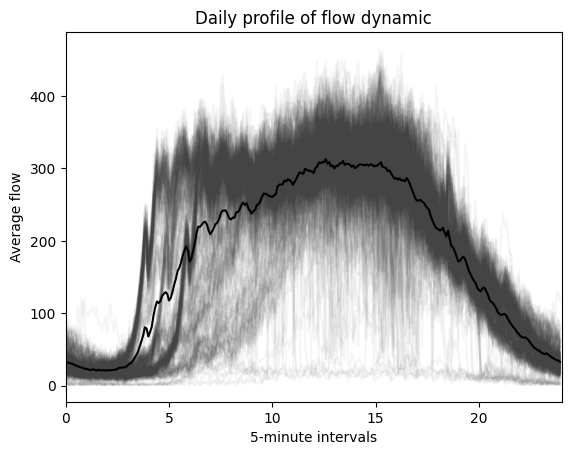

In [8]:
fig, ax = plt.subplots()
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),vectorized_day_dataset.transpose(),color='#444444',alpha=0.05)
ax.plot(x_axis_hours,np.transpose(np.nanmean(vectorized_day_dataset,0)),color='black')


ax.set_ylabel('Average flow')
ax.set_xlabel('5-minute intervals')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')

plt.show()

Some patterns are obvious, and we could expect some peak and weekend patterns. Thus, a simple thing to do is look at day-of-week patterns, done below.

In [9]:
import datetime

day_of_week = np.zeros((ndays))
for i in range(0,ndays):
  day_dt = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
  day_of_week[i] = day_dt.isoweekday()


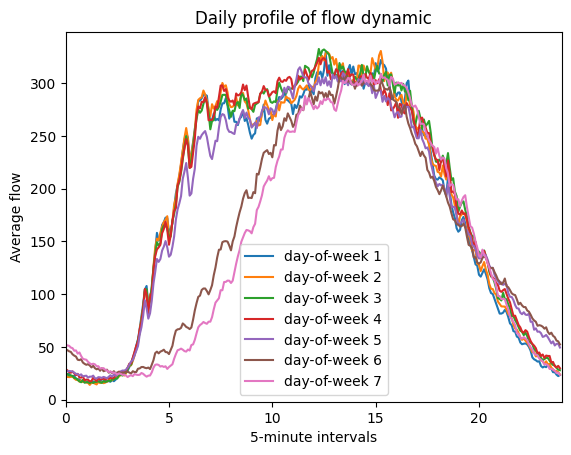

In [13]:
fig, ax = plt.subplots()
for i in range(1,8):
  day_of_week_index_t = np.where(day_of_week == i)
  ndays_t = np.size(day_of_week_index_t[0])
  ax.plot(x_axis_hours,
          np.nanmean(vectorized_day_dataset[day_of_week_index_t[0],:].transpose(),1),
   label = 'day-of-week '+str(i))


ax.set_ylabel('Average flow')
ax.set_xlabel('5-minute intervals')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')
ax.legend()
plt.show()

The day's index is from 1 - 7, where 1 is Monday. To our expectations, we can see the difference between weekdays and weekends. However, some patterns from the previous plot are missing here and may include seasonal, holiday, and incident impacts on observations. This we explore with clustering in the next part of the exercise.

# Part 2: Clustering

In this part, you will work on revealing patterns using traffic observations and clustering methods.

## Clustering

Using clustering methods in scikit-learn is relatively simple, as shown below. With one line of code, you can get some clusters. However, this will need some work to search for representative clusters. This is the first step to pattern exploration.

In [76]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

clusters = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(vectorized_day_dataset)


ValueError: ignored

As you can see k-means clustering method can not handle missing values, so you have choices: impute data or remove them. We will just remove all days that have missing observations. Fewer days would be removed if we restrict the clustering to a particular day-time period, 06:00 - 22:00:00. Below, we prepare a new dataset without missing values and update the list of days for later visualization purposes.

In [77]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]
clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
#clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
  cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)

[4 4 4 9 1 4 9 9 4 4 9 9 9 9 9 4 4 9 3 3 3 3 4 4 9 9 9 9 4 4 9 9 9 9 9 4 4
 9 9 9 9 3 4 4 9 3 3 3 4 4 3 3 3 3 4 4 3 3 9 3 9 4 4 3 9 3 9 3 4 4 3 3 3 3
 3 4 4 3 3 9 3 3 4 3 3 4 4 4 4 9 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3
 3 3 3 4 1 2 2 2 2 2 1 1 2 2 6 8 8 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 6 2 6 1 1
 2 2 6 6 6 1 1 2 6 2 2 8 1 1 2 2 6 2 1 4 1 6 8 2 0 8 1 7 8 6 8 1 1 8 8 8 8
 8 1 1 8 8 8 8 8 1 1 8 8 1 1 8 8 8 7 1 1 8 8 8 2 6 1 1 2 2 2 2 6 1 1 2 2 2
 6 6 1 1 2 2 2 2 6 1 2 1 1 2 2 6 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 7 2 2 2 1 1
 2 2 2 2 6 1 1 2 2 2 6 8 1 1 6 2 2 2 1 1 5 5 5 5 4 1 5 5 5 5 1 1 5 5 5 5 5
 1 1 5 5 5 5 5 1 4 5 5 5 5 5 4 4 5 5 5 9 1 4 5 5 5 5 5 1 4 5 5 5 8 4 4 4 1
 1 1 1 4]


## Visualizaiton of representative day-type patterns

### Special plots for visualizing day-type patterns

the results of clusterings are assignments to the clusters, this can be hard to read and make conclusions about it, so visualization of data in right way is of high importance. Below script gives you set of libraries for calendar and centroid visualizaiton.

***Note: The below script you do not have to understand. Consider it as an external library that will plot for you, just like a histogram plot, for which you also do not know the exact implementation. Anyway, this course does not focus on information visualization.***

In [26]:

from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



### Visualization

#### Calendar visualization

Using above functions for visualization, the representative day-type clusters can be visualize in form of calendar in order to enable for us by-eye analysis to make sense of these clusters. What is your reflection about them? Note that white cells are removed days because of missing observations

cluster_id_weekdays_share [1, 34, 25, 42, 5, 32, 24, 68, 4, 1]
cluster_id_weekend_share [36, 0, 0, 0, 15, 0, 6, 0, 42, 2]
111


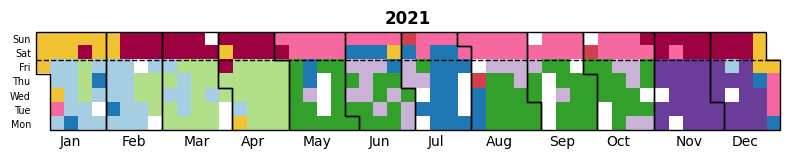

In [64]:
n_clusters_t = len(np.unique(cluster_labels))
days_colors,color_to_cluster,style_to_cluster = assign_colors(n_clusters_t,days_not_nans,cluster_labels)

make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)


#### Day-time profile of centroids

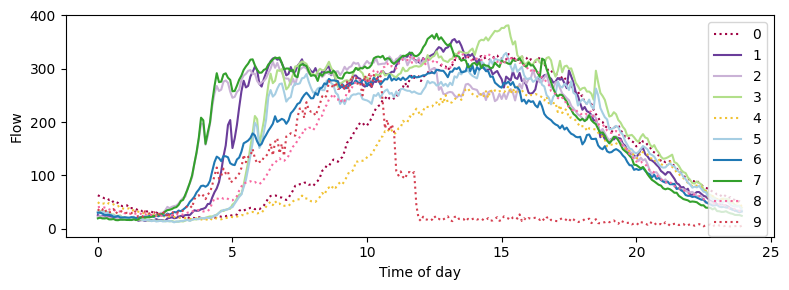

In [65]:
centroids_xx = []
centroids_yy_daytypes = []
cluster_ids = []
for i in range(0,n_clusters_t):
  centroids_xx.append(x_axis_hours)
  centroids_yy_daytypes.append(list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0],:],0).transpose()))
  cluster_ids.append(i)

make_figure_centroids(centroids_xx,centroids_yy_daytypes,color_to_cluster,style_to_cluster,cluster_ids)

Next, we can explore thei day-type profilex

As you can see with first shot using k-means we can much more day-type patterns as we may expect, it even enable to identify potential outliers like cluster 7 or possible incident/outlier day 1

# Part 3: Independent work - clustering evaluation

Find the day-type clusterings that you consider most representative. Evaluate clustering quality using internal evaluation metrics such as Silhouette score and others. You can consider short-term prediction as an external metric that imitates how useful recognized patterns are compared to newly observed days. In an assignment, motivate why you consider the method selected by you as superior.

**NOTE** ***This part of exercise as well with all you have learned about clustering is the basis for your reflection in mandatory grated assignment for the MODULE 5***

You can use above and below scripts for experimenting with different methods, metrics and number of clusters

## Internal evaluation

Below is just example for using internal metrics in scikit-learn

In [67]:

from sklearn.metrics import calinski_harabasz_score,silhouette_score,davies_bouldin_score

SC_score = silhouette_score(vectorized_day_dataset_no_nans,cluster_labels)
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans,cluster_labels)
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans,cluster_labels)

print('silhouette_score',SC_score)
print('davies_bouldin_score',DB_score)
print('calinski_harabasz_score',CH_score)

silhouette_score 0.17983503869358244
davies_bouldin_score 1.7506265035326394
calinski_harabasz_score 81.90976553121779


## External evaluation with short-term prediction

First, lets load the evaluation dataset used of evaluating short-term prediction accuracy, vectorize it to day vectors and remove missing values.

In [68]:
data_eval_df = pd.read_csv("evaluation_dataset_exercise_5_clustering_highway_traffic.csv",sep=";")

data_eval_df.sort_values(["Date","Interval_5"])
days_eval = np.unique(data_eval_df[['Date']].values.ravel())
ndays_eval = len(days_eval)
day_eval_subsets_df = data_eval_df.groupby(["Date"])
vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
vectorized_day_dataset_eval.fill(np.nan)
for i in range(0, ndays_eval):
  df_t = day_eval_subsets_df.get_group(days_eval[i])
  for j in range(len(df_t)):
      df_t = day_eval_subsets_df.get_group(days_eval[i])
      vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]
print(vectorized_day_dataset_eval)


[[16.74 17.57 16.94 ... 19.43 19.88 19.73]
 [19.17 19.26 20.98 ... 19.34 21.22 19.79]
 [19.69 19.39 19.76 ... 20.51 20.5  19.6 ]
 ...
 [19.65 22.59 20.8  ... 19.23 20.32 20.18]
 [19.75 19.96 20.95 ... 17.95 19.14 19.55]
 [20.82 20.28 20.5  ... 19.72 20.64 20.23]]


In [69]:
print('number of nans',np.sum(np.isnan(vectorized_day_dataset_eval)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset_eval))/(ndays_eval*nintvals))
nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval),1)
print('number of days with missing value',np.size(np.where(nans_per_day_eval > 0),1))

#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0],:]
days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]
print('final number of days in evaluation:',len(days_not_nans_eval))
print('list of days:',days_not_nans_eval)
ndays_eval_not_nans = len(days_not_nans_eval)

number of nans 96
rate of nans 0.004166666666666667
number of days with missing value 11
final number of days in evaluation: 69
list of days: [20220108 20220109 20220131 20220204 20220209 20220210 20220211 20220223
 20220226 20220227 20220302 20220304 20220305 20220306 20220310 20220314
 20220315 20220321 20220323 20220326 20220403 20220406 20220416 20220418
 20220421 20220422 20220425 20220427 20220428 20220503 20220505 20220514
 20220519 20220521 20220522 20220526 20220530 20220601 20220603 20220609
 20220616 20220619 20220623 20220628 20220704 20220711 20220712 20220904
 20220910 20220911 20220920 20220921 20220925 20220927 20220929 20220930
 20221005 20221022 20221024 20221114 20221116 20221121 20221122 20221213
 20221216 20221218 20221220 20221223 20221230]


Now when the dataset for evaluation is ready, below is a script for evaluating short-term prediction performance.

Prediction works like this for each day at current interval *j*; we use 5 last past intervals to find the closest centroid. This average centroid is used as the source of the prediction for future time interval *j+1*. This directly measures how the representative pattern matches the new future days not part of your training and thus evaluates the clustering to external data and not as internal metrics.

In [70]:
import sklearn.metrics.pairwise as dis_lib

def find_the_closest_centroid(centroids,new_day,from_interval:int,to_interval:int):
  closest_centroid = None
  closest_dist = None
  for i in range(0,len(centroids)):
    ed_t = dis_lib.paired_distances(centroids[i],new_day,metric='euclidean')
    if closest_centroid is None or closest_dist > ed_t:
      closest_centroid = i
      closest_dist = ed_t
  return closest_centroid

centroids = []

for i in range(0,n_clusters_t):
  centroids.append(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0],:],0).reshape(1,nintvals))

n_past_intervals_for_classification = 5

total_mae = 0
total_mape = 0
prediction_counts = 0
for i in range(0,ndays_eval_not_nans):
  for j in range(n_past_intervals_for_classification,nintvals-1):
    centroid_index = find_the_closest_centroid(centroids,vectorized_day_dataset_no_nans_eval[i].reshape(1,nintvals),j-n_past_intervals_for_classification,j)
    predicted_value = centroids[centroid_index][0,j + 1]
    mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
    mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])/float(vectorized_day_dataset_no_nans_eval[i][j + 1])
    total_mae += mae_t
    total_mape += mape_t
    prediction_counts += 1

print('Prediction accuracy MAE',total_mae / prediction_counts)
print('Prediction accuracy MAPE',total_mape / prediction_counts)


Prediction accuracy MAE 59.98865522321583
Prediction accuracy MAPE 3.318357803607238
